In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Implement Loess

In [10]:
def bisquare_weight(u):
    """Tricubic-Weight-Funktion"""
    result = np.power(1 - np.power(u, 2), 2)
    result[np.abs(u) > 1] = 0
    return(result)

def tricubic_weight(u):
    """Tricubic-Weight-Funktion"""
    result = np.power(1 - np.power(u, 3), 3)
    result[np.abs(u) > 1] = 0
    return(result)


def loess_series(u, series, q = None, d = 2, weights = None):
    """
    u - point to be estimated
    x - independent variable
    y - dependent variable
    q - cutting point
    d - the order of the local polynomial
    weights - reliability weights used as a multiplicator in the local regression
    """
    #Drop Missing Values in Series and Reliabilty-Weights
    idx_notnan = ~np.array(series.isna())
    series = series[idx_notnan]
    if weights is not None:
        weights = weights[idx_notnan]
    
    #Compute length of series
    n = len(series)
    
    
    smoothed_series = pd.Series()
    for val in u:
        if q is None:
            q = int(2.5 * np.log(n))
    
        if q < n:
            idx = np.argsort(np.abs(val-series.index))[:q]
            x_reg = np.array((val - series.index[idx]).total_seconds())
            y_reg = series.values[idx]
            reg_weights = tricubic_weight(np.abs(x_reg) / np.max(np.abs(x_reg)))
            if weights is not None:
                reg_weights = reg_weights * weights[idx] 
        elif q >= n:
            x_reg = np.array((val - series.index).total_seconds())
            y_reg = series.values
            reg_weights = tricubic_weight(np.abs(x_reg) / (np.max(np.abs(x_reg)) * q / n))
            if weights is not None:
                reg_weights = reg_weights * weights
        
        coeff = np.polyfit(x = x_reg, y = y_reg, deg = d, w = reg_weights)
        smoothed_series[val] = np.poly1d(coeff)(0)
    return(smoothed_series)

# Implement STL

In [12]:
# Sub-Cycle Smoothing
def subcycle_smoothing(series, n_p = 7, n_s = 5, n_i = 1, n_o = 10, weights = None):
    
    start = min(series.index) - n_p
    end = max(series.index) + n_p
    idx = pd.DatetimeIndex(freq = series.index.inferred_freq, start = start, end = end)
    series_expanded = series.copy().reindex(idx)
    
    if weights is not None:
        weights_expanded = np.zeros(len(series_expanded))
        weights_expanded[~series_expanded.isna()] = weights
        
    
    
    for cycle in range(n_p):
        cycle_subseries = series_expanded.copy().iloc[cycle:len(series_expanded):n_p]
        if weights is not None:
            w = bisquare_weight(weights_expanded[cycle:len(series_expanded):n_p])
        else:
            w = None
        new_cycle_subseries = loess_series(cycle_subseries.index, cycle_subseries, q = n_s, d = 1, weights = w)
        series_expanded.update(new_cycle_subseries)
        
    return(series_expanded)

def lowpass_filtering(series, n_p, n_l):
    filtered_series = series.rolling(n_p, center = True).mean().dropna()
    filtered_series = filtered_series.rolling(n_p, center = True).mean().dropna()
    filtered_series = filtered_series.rolling(3, center = True).mean().dropna()
    
    filtered_series = loess_series(filtered_series.index, filtered_series, q = n_l, d = 1).dropna()
    
    return(filtered_series)

class STL:
    def __init__(self, series, season, trend, error):
        self.ts = series
        self.season = season
        self.trend = trend
        self.error = error
    def plot(self):
        self.season.plot(title = 'season')
        plt.figure()
        self.trend.plot(title = 'trend')
        plt.figure()
        self.error.plot(title = 'error')

def stl_decompose(series, n_p, n_s, n_t = None, n_l = None, n_o = 5, n_i = 2):
    """ This is the STL-Decomposition from ..."""
    
    if n_l is None:
        n_l = int(np.ceil(n_p) // 2 * 2 + 1)
    n_s = max(int(np.ceil(n_s) // 2 * 2 + 1), 7)
    if n_t is None:
        n_t = 1.5 * n_p / (1 - 1.5 / n_p)
    n_t = int(np.ceil(n_t) // 2 * 2 + 1)    
    
    trend_ts = pd.Series(data = 0, index = series.index)
    robustness_weights = None
    for outer in range(n_o):
        for _ in range(n_i):
            ts_detrended = series - trend_ts
            cycle_ts = subcycle_smoothing(ts_detrended.copy(), n_s = n_s, weights = robustness_weights)
            season_ts = (cycle_ts - lowpass_filtering(cycle_ts, n_p, n_l)).dropna()
            ts_deseasonalized = series - season_ts
            trend_ts = loess_series(ts_deseasonalized.index, ts_deseasonalized, q = n_t, d = 1, weights = robustness_weights)
        
            error_ts = series - season_ts - trend_ts
        robustness_weights = bisquare_weight(np.abs(np.array(error_ts)) / (6 * np.median(np.abs(error_ts))))
    return(STL(series, season_ts, trend_ts, error_ts))    

# ToDos
- implement heuristics
- check for usefulness of decomposition aka too many np.NaNs
- "copy" definitions of decomposition-class from stats-modul
- insert tests

# Tests

## Test of Loess

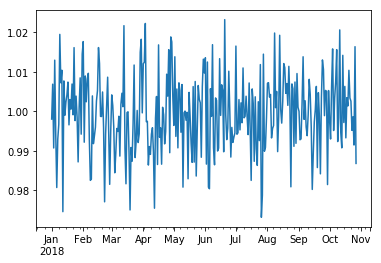

In [13]:
#Test of Loess
length = 300
weights = np.ones(length)
weights[150] = 0.01
data = 1 + np.random.normal(scale = 0.01, size = length)
idx = pd.date_range(start = '2018-01-01', periods = length)
series = pd.Series(data = data, index = idx)
#series[idx[150]] = 100
series.plot()

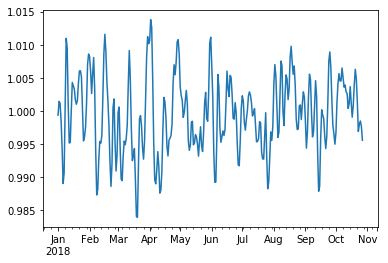

In [14]:
loess_series(series.index, series, q = 10, d = 2).plot()

## Test of STL

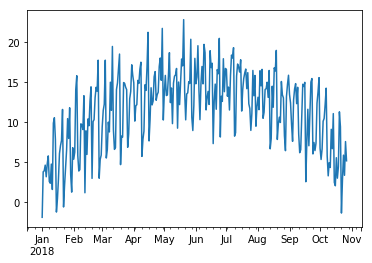

In [34]:
np.random.seed(42)
x = np.arange(0, 300)
idx = pd.date_range('2018-01-01', periods = len(x))
season = pd.Series(((x % 7) - 3) * 1.5, idx)
trend = pd.Series(x * 0.15, idx) - pd.Series(np.power(x * 0.022, 2), idx)
error = pd.Series(np.random.random(len(x))*7, idx)
y = season + trend + error
y.plot()

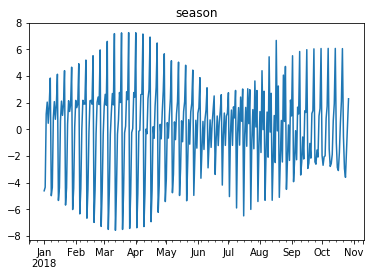

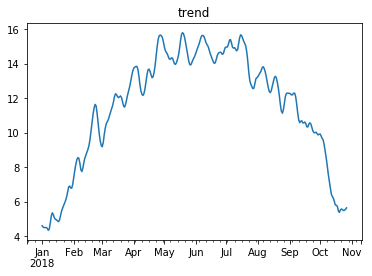

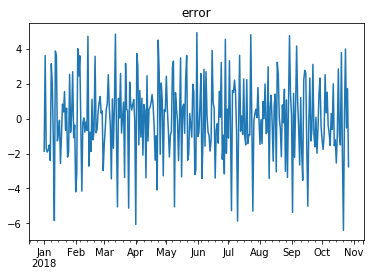

In [35]:
decomposition = stl_decompose(y, 7, 21, n_o = 3, n_i = 1)
decomposition.plot()

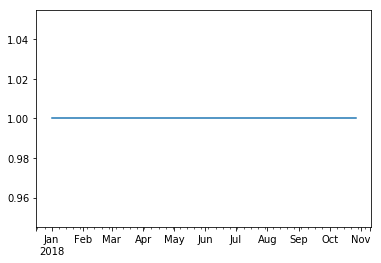

In [33]:
#Test of Loess
weights = np.ones(300)
weights[50] = 0.01
data = 1
idx = pd.date_range(start = '2018-01-01', periods = 300)
y = pd.Series(data = data, index = idx)
#y[idx[50]] = 100
y.plot()

In [10]:
decomposition = stl_decompose(y, 7, 11, 11, 11, 3, 1)

f:\programdata\anaconda3\lib\site-packages\numpy\lib\polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
f:\programdata\anaconda3\lib\site-packages\numpy\lib\polynomial.py:586: RuntimeWarning: divide by zero encountered in true_divide
  c = (c.T/scale).T  # broadcast scale coefficients
f:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned
f:\programdata\anaconda3\lib\site-packages\numpy\lib\polynomial.py:680: RuntimeWarning: invalid value encountered in double_scalars
  y = y * x + p[i]


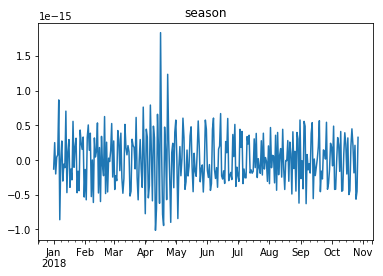

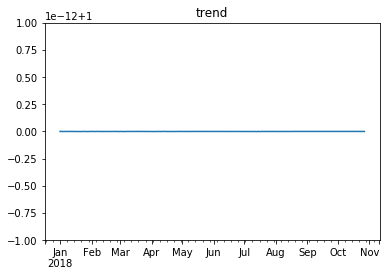

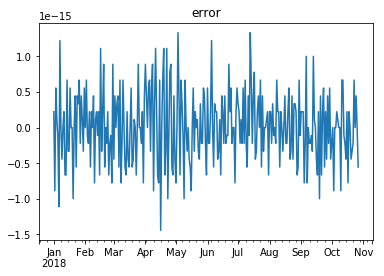

In [11]:
decomposition.plot()

In [12]:
np.random.seed(42)
x = np.array(range(300))
idx = pd.date_range('2018-01-01', periods = len(x))
trend = pd.Series(x * 0.5, idx)

In [13]:
decomposition = stl_decompose(trend, 7, 11, 11, 11, 10, 1)

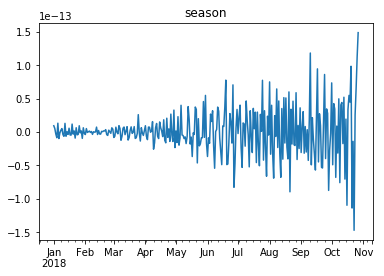

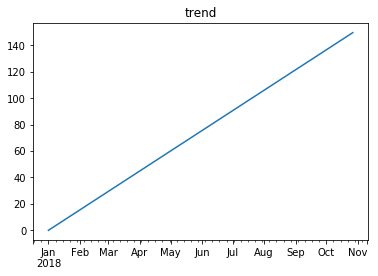

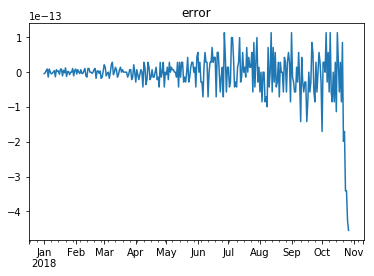

In [14]:
decomposition.plot()

In [15]:
np.random.seed(42)
idx = pd.date_range('2018-01-01', periods = len(x))
trend = pd.Series(x * 0.15, idx) - pd.Series(np.power(x * 0.022, 2), idx)

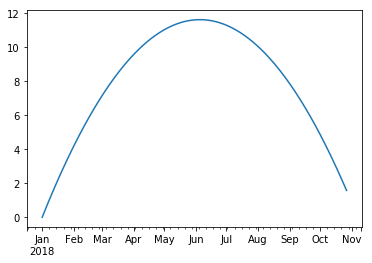

In [16]:
trend.plot()

In [17]:
decomposition = stl_decompose(trend, 7, 11, 11, 11, 10, 1)

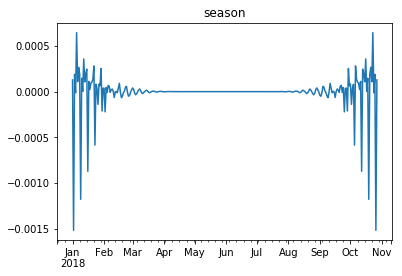

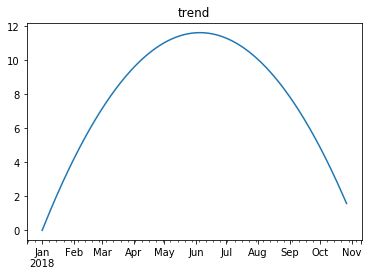

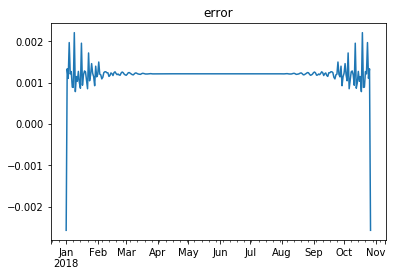

In [18]:
decomposition.plot()